In [1]:
import pandas as pd
import numpy as np
import os
import gzip
import jsonlines
import importlib
import sys
import nltk
import json
from tqdm import tqdm
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download(['stopwords','wordnet'])
stopwords = set(stopwords.words("english"))

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /home/peichi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/peichi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Analysis

In [2]:
FIG_PATH = "results/"
dataset_file_path = "data/postings_dataset.jsonl"
postings_filename = "data/predicted_postings.csv.gz"
job_category_filename = "data/job_categories.json"
category_info_filename = 'data/category_info.json'
label2id_filename = 'data/label2id.json'
resume_data_filename = "data/resume_data.csv"
training_filename_temp = "data/train_rel_temp.csv"
training_filename = "data/train_relevance.csv"
testing_filename_temp = "data/test_rel_temp.csv"
testing_filename = "data/test_relevance.csv"
embeddings_filename = "data/description_embeddings.all-MiniLM-L6-v2.npy"
aug_embeddings_filename = "data/augmented_description_embeddings.all-MiniLM-L6-v2.npy"
COMPANY_RATINGS_PATH = 'data/company_reviews.csv'

In [3]:
postings_data = pd.read_csv(postings_filename)
postings_cat = postings_data["predicted"].value_counts(dropna=False)
postings_cat

predicted
INFORMATION-TECHNOLOGY    23451
HEALTHCARE                21867
SALES                     16224
BUSINESS-DEVELOPMENT      14769
HR                        11424
ENGINEERING                8763
ACCOUNTANT                 4223
FINANCE                    3667
ADVOCATE                   2421
CONSULTANT                 2388
TEACHER                    2279
CHEF                       1829
DESIGNER                   1824
CONSTRUCTION               1677
BANKING                    1669
AUTOMOBILE                 1627
FITNESS                    1206
BPO                         915
AVIATION                    879
PUBLIC-RELATIONS            740
Name: count, dtype: int64

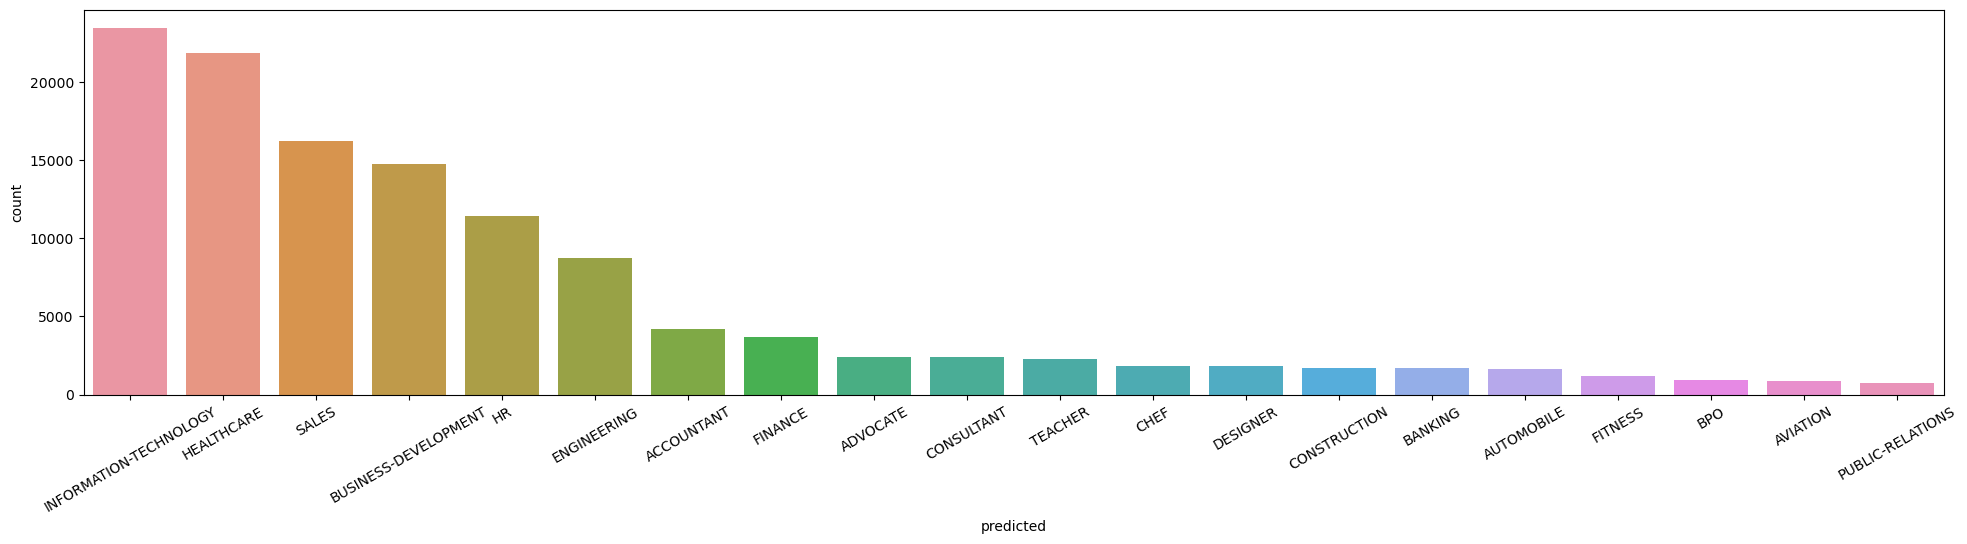

In [4]:
plt.figure(figsize=(24,5))
plt.xticks(rotation=30)
postings_cat = pd.DataFrame(postings_cat).reset_index().rename(columns={"index": "value", 0: "count"})
sns.barplot(x='predicted', y='count', data=postings_cat)
plt.savefig(FIG_PATH + "postings_categories.png")

# Evaluation

In [3]:
# importlib.reload(sys.modules['relevance'])
from relevance import run_relevance_tests

In [4]:
SCORE_PATH = FIG_PATH + 'scores.json'
def save_score(scores, filepath):    
    with open(filepath, 'w') as fp:
        json.dump(scores, fp, indent = 4) 

def load_score(filepath):
    with open(filepath) as f:
        s = json.load(f)
    return s

In [5]:
if os.path.exists(SCORE_PATH):
    scores = load_score(SCORE_PATH)
else:
    scores = {}

## Indexing

In [6]:
# importlib.reload(sys.modules['indexing'])
from indexing import Indexer, IndexType, BasicInvertedIndex
from document_preprocessor import RegexTokenizer

/home/peichi/.local/lib/python3.11/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [7]:
print('initializing tokenizer...')
preprocessor = RegexTokenizer('\w+')

print('reading stopwords...')
stopwords = stopwords

print('indexing document...')
title_index_directory_name = 'data/index-title'
if os.path.exists(title_index_directory_name):
    print('- reading title index from file...')
    title_index = BasicInvertedIndex()
    title_index.load(title_index_directory_name)
else:
    print('- creating title index...')
    title_index = Indexer.create_index(
        IndexType.BasicInvertedIndex, dataset_file_path, preprocessor, stopwords, 0, text_key='title')
print("number of documents", title_index.statistics['number_of_documents'])
main_index_directory_name = 'data/index-description_mwf10'
if os.path.exists(main_index_directory_name):
    print('- reading document index from file...')
    main_index = BasicInvertedIndex()
    main_index.load(main_index_directory_name)
else:
    print('- creating document index...')
    main_index = Indexer.create_index(
        IndexType.BasicInvertedIndex, dataset_file_path, preprocessor, stopwords, 10, text_key="description")
print("number of documents", main_index.statistics['number_of_documents'])

initializing tokenizer...
reading stopwords...
indexing document...
- reading title index from file...
number of documents 123842
- reading document index from file...
number of documents 123842


## BM25 Ranking

In [10]:
from ranker import BM25, Ranker

scorer = BM25(main_index) # {'b': 0.75, 'k1': 1.2, 'k3': 8, 'threshold': 5}
ranker = Ranker(main_index, preprocessor, stopwords, scorer)

#### Scoring

In [11]:
scores['bm25'] = run_relevance_tests(resume_data_filename, testing_filename, ranker)
scores['bm25']

100%|██████████| 248/248 [1:36:37<00:00, 23.38s/it]


{'map': 0.21075940860215073,
 'ndcg': 0.295803893920555,
 'map_list': [0.2988095238095238,
  0.07222222222222222,
  0.12,
  0.12222222222222223,
  0.3480952380952381,
  0.1,
  0.0,
  0.05333333333333333,
  0.0,
  0.14666666666666667,
  0.04,
  0.29,
  0.01,
  0.4383333333333333,
  0.4891666666666666,
  0.6,
  0.0125,
  0.26666666666666666,
  0.30964285714285716,
  0.03111111111111111,
  0.0,
  0.27380952380952384,
  0.6366666666666667,
  0.4625,
  0.20047619047619047,
  0.2,
  0.4864285714285714,
  0.27111111111111114,
  0.08273809523809524,
  0.0,
  0.0,
  0.01111111111111111,
  0.0,
  0.2544444444444444,
  0.55,
  0.4279761904761905,
  0.14952380952380953,
  0.0,
  0.20999999999999996,
  0.11333333333333333,
  0.0,
  0.736547619047619,
  0.5380952380952382,
  0.16607142857142856,
  0.0,
  0.38,
  0.4425,
  0.01111111111111111,
  0.5880952380952381,
  0.0,
  0.19285714285714287,
  0.2984126984126984,
  0.07333333333333333,
  0.36714285714285716,
  0.01,
  0.3638888888888888,
  0.50087

### BM25 with threshold

In [12]:
# scorer = BM25(main_index, {'b': 0.75, 'k1': 1.2, 'k3': 8, 'threshold': 5})
# ranker = Ranker(main_index, preprocessor, stopwords, scorer_t)

In [13]:
# scores['bm25_truncate'] = run_relevance_tests(resume_data_filename, testing_filename, ranker_t)
# scores['bm25_truncate']

## Major Class Ranking

In [14]:
# importlib.reload(sys.modules['class_ranker'])
from class_ranker import MajorClassRanker

mc_ranker = MajorClassRanker(postings_filename)

#### Scoring

In [15]:
scores['mc'] = run_relevance_tests(resume_data_filename, testing_filename, mc_ranker)
scores['mc']

100%|██████████| 248/248 [00:01<00:00, 192.24it/s]


{'map': 0.00047043010752688175,
 'ndcg': 0.0015216111500496198,
 'map_list': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.03333333333333333,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.03333333333333333,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0

In [16]:
mc_ranker.major_cat

'INFORMATION-TECHNOLOGY'

## Random Class Ranking

In [17]:
# importlib.reload(sys.modules['class_ranker'])
from class_ranker import RandomClassRanker

rc_ranker = RandomClassRanker(postings_filename)

#### Scoring

In [18]:
scores['rc'] = run_relevance_tests(resume_data_filename, testing_filename, rc_ranker)
scores['rc']

100%|██████████| 248/248 [00:00<00:00, 570.60it/s]


{'map': 0.00028225806451612906,
 'ndcg': 0.006036016528997513,
 'map_list': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.02,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,


In [19]:
used_cat = Counter(rc_ranker.used_cat)
used_cat

Counter({'PUBLIC-RELATIONS': 21,
         'ENGINEERING': 17,
         'AVIATION': 15,
         'TEACHER': 15,
         'CHEF': 14,
         'DESIGNER': 14,
         'CONSULTANT': 13,
         'INFORMATION-TECHNOLOGY': 13,
         'HR': 13,
         'BPO': 13,
         'SALES': 12,
         'ACCOUNTANT': 12,
         'BUSINESS-DEVELOPMENT': 12,
         'CONSTRUCTION': 11,
         'FITNESS': 11,
         'ADVOCATE': 11,
         'FINANCE': 9,
         'AUTOMOBILE': 9,
         'BANKING': 7,
         'HEALTHCARE': 6})

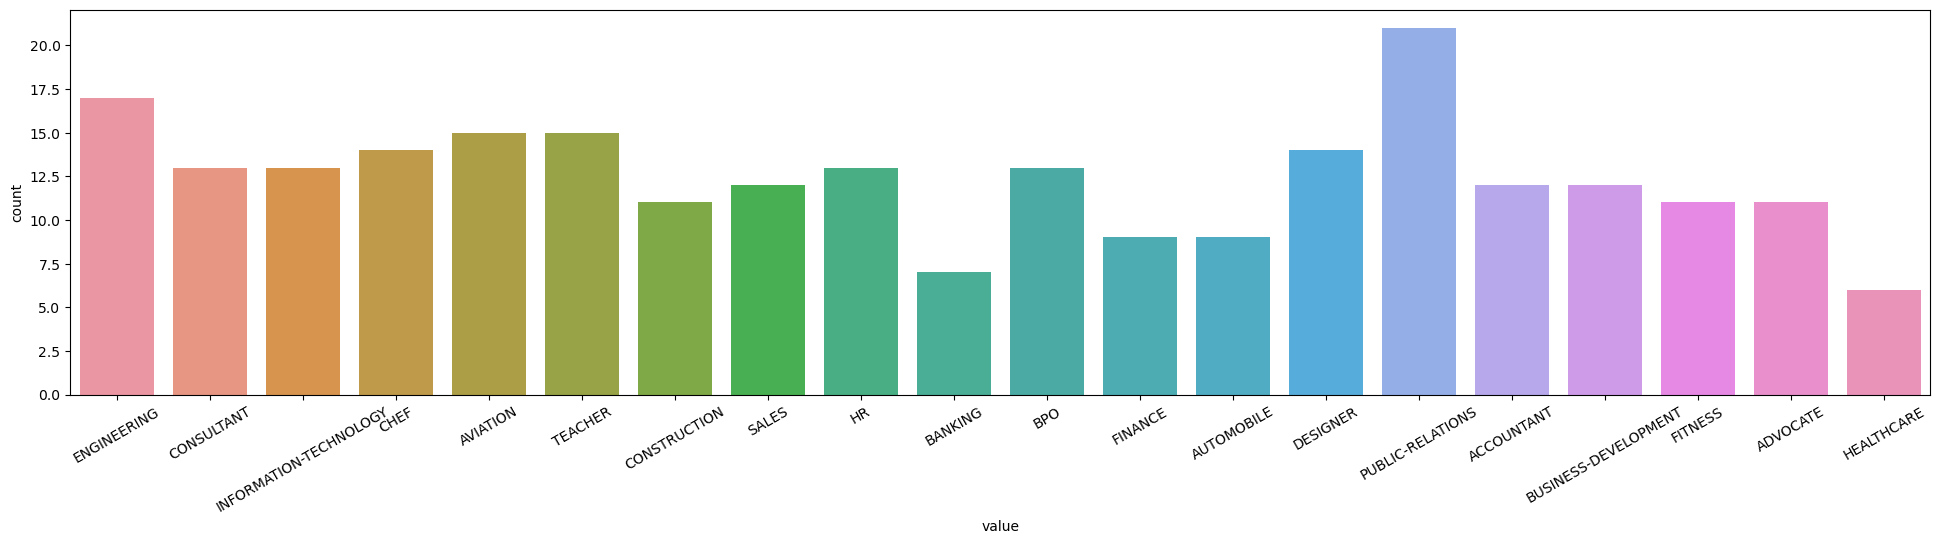

In [20]:
plt.figure(figsize=(24,5))
plt.xticks(rotation=30)
used_cat = pd.DataFrame.from_dict(used_cat, orient="index").reset_index().rename(columns={"index": "value", 0: "count"})
sns.barplot(x="value", y="count", data=used_cat)
plt.savefig(FIG_PATH + "random_cat.png")

## LLM Ranking

In [21]:
# importlib.reload(sys.modules['class_ranker'])
from class_ranker import LLMRanker

llm_model_name = './posting_classifier/models/job_classification_11091504'
llm_ranker = LLMRanker(llm_model_name, postings_filename)

#### Scoring

In [22]:
scores['llm'] = run_relevance_tests(resume_data_filename, testing_filename, llm_ranker)
scores['llm']

100%|██████████| 248/248 [00:12<00:00, 20.00it/s]


{'map': 0.011994847670250892,
 'ndcg': 0.028133369199165908,
 'map_list': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.02,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.12222222222222223,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.27194444444444443,
  0.0,
  0.02,
  0.0,
  0.0,
  0.0,
  0.03333333333333333,
  0.0,
  0.16999999999999998,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.19952380952380952,
  0.0,
  0.16666666666666666,
  0.0,
  0.0,
  0.01,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0125,
  0.0,
  0.0,
  0.0,
  0.02,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.27666666666666667,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.04523809523809523,
  0.0,
  0.0,
  0.19,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.1,
  0.0,
  0.02,
  0.016666666666666666,
  0.0,
  0.16999999999999998,
 

In [23]:
save_score(scores, SCORE_PATH)

## L2R with BM25 Ranking

#### Process category info

In [8]:
with open(job_category_filename) as f:
    label2cat = json.load(f)

fields = []
for i in label2cat:
    fields.append(label2cat[i])
fields = list(set(fields))

if os.path.exists(category_info_filename):
    with open(category_info_filename) as f:
        temp = json.load(f)

    doc_category = {}
    for key in temp:
        doc_category[int(key)] = temp[key]
    del temp
    
    with open(label2id_filename) as f:
        label2id = json.load(f)
else:
    from sklearn.preprocessing import LabelEncoder
    
    le = LabelEncoder()
    le.fit(list(label2cat.keys()))
    
    labels = le.classes_
    label2id = {}
    for i, cat in enumerate(labels):
        label2id[cat] = i

    doc_category = {}
    for i in tqdm(range(len(postings_data))):
        l = postings_data.iloc[i]["predicted"]
        cat = [1 if i == label2id[l] else 0 for i in range(len(label2id))] \
                + [postings_data.iloc[i]["scores"]] \
                + [1 if label2cat[l] == fields[i] else 0 for i in range(len(fields))]
        doc_category[int(postings_data.iloc[i]["job_id"])] = cat

    with open(category_info_filename, 'w') as f:
        json.dump(doc_category, f)
    with open(label2id_filename, 'w') as f:
        json.dump(label2id, f)

#### Initialize L2R

In [25]:
# importlib.reload(sys.modules['l2r'])
from l2r import L2RFeatureExtractor, L2RRanker
from vector_ranker import VectorRanker

print("creating feature extractor...")
fe = L2RFeatureExtractor(main_index,
                            title_index,
                            doc_category,
                            preprocessor,
                            stopwords
                            # recognized_categories,
                            # network_features
                        )

print("creating l2r ranker...")
l2r_bm25 = L2RRanker(main_index, title_index, preprocessor, \
                    stopwords, ranker, fe)

creating feature extractor...
creating l2r ranker...


In [26]:
print('training...')
l2r_bm25.train(training_filename, resume_data_filename, "l2r_bm25_train_data")

training...
load training data from path...
training...
[LightGBM] [Info] Total Bins 2259
[LightGBM] [Info] Number of data points in the train set: 73083, number of used features: 33


#### Scoring

In [27]:
scores['l2r_bm25'] = run_relevance_tests(resume_data_filename, testing_filename, l2r_bm25)
scores['l2r_bm25']

100%|██████████| 248/248 [1:59:04<00:00, 28.81s/it]  


{'map': 0.11501952124936002,
 'ndcg': 0.20032349624835574,
 'map_list': [0.05333333333333333,
  0.0,
  0.01,
  0.05,
  0.05,
  0.06666666666666667,
  0.0,
  0.014285714285714285,
  0.0,
  0.02,
  0.0,
  0.4597619047619048,
  0.0,
  0.1873015873015873,
  0.23888888888888887,
  0.17666666666666667,
  0.0,
  0.1,
  0.27166666666666667,
  0.0,
  0.0,
  0.28174603174603174,
  0.23166666666666663,
  0.0919047619047619,
  0.13333333333333333,
  0.03333333333333333,
  0.2761904761904762,
  0.10222222222222221,
  0.1,
  0.0,
  0.0,
  0.0,
  0.0,
  0.22063492063492066,
  0.075,
  0.014285714285714285,
  0.05,
  0.0,
  0.4,
  0.11499999999999999,
  0.014285714285714285,
  0.28055555555555556,
  0.40309523809523806,
  0.014285714285714285,
  0.0,
  0.095,
  0.1269047619047619,
  0.12,
  0.38769841269841265,
  0.0,
  0.0,
  0.13999999999999999,
  0.0125,
  0.28055555555555556,
  0.0,
  0.01,
  0.06190476190476191,
  0.13551587301587303,
  0.3255555555555555,
  0.1,
  0.0125,
  0.0,
  0.416309523809

In [28]:
save_score(scores, SCORE_PATH)

plot feature importance...
- number of used features 37
['doc_len', 'title_len', 'query_len', 'doc_tf', 'doc_tf_idf', 'title_tf', 'title_tf_idf', 'bm25', 'pivoted norm', 'cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27']
plot feature importance...
binary features importance...
   feature  importance
33   cat24  182.734019
27   cat18   14.096591
18    cat9   13.935980
31   cat22   13.325580
9     cat0    9.387670


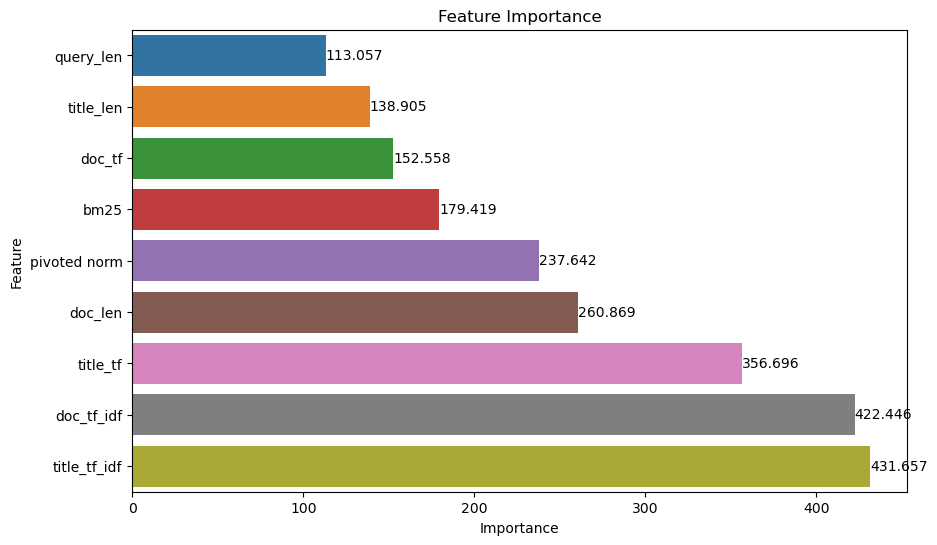

In [30]:
print('plot feature importance...')
feature_names = [
        'doc_len', 'title_len', 'query_len',
        'doc_tf', 'doc_tf_idf', 'title_tf', 'title_tf_idf',
        'bm25', 'pivoted norm', #'pagerank', 'HITS hub', 'HITS auth',
        # 'skill similarity'
        # 'cross encoder',
        #'title_myscore', 'doc_myscore', 'total_cat'
]
num_binary = len(feature_names)
num_cat = len(l2r_bm25.model.ranker.feature_name_) - len(feature_names)
for i in range(num_cat):
    feature_names.append(f'cat{i}')
print("- number of used features", len(l2r_bm25.model.ranker.feature_name_))
print(feature_names)
importance = l2r_bm25.model.ranker.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
})
df_binary = importance_df.iloc[num_binary:]
df = importance_df.iloc[:num_binary]
df = df.sort_values(by=['importance'])

# Plot feature importance
print('plot feature importance...')
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x='importance', y='feature')
ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.savefig(FIG_PATH + 'feature_importance_bm25.png')

print('binary features importance...')
df_binary = importance_df.iloc[num_binary:]
df_binary = df_binary.sort_values(by=['importance'], ascending=False)
print(df_binary.head(5))

## L2R with VectorRanker Ranking

#### Load document raw text

In [9]:
document_dict = {}
if dataset_file_path.endswith('.gz'):
    with gzip.open(dataset_file_path, 'rt', encoding='utf-8') as f:
        for line in tqdm(f):
            print(line)
            doc = json.loads(line)
            document_dict[doc['job_id']] = doc['description']
else:
    with jsonlines.open(dataset_file_path) as f:
        for doc in tqdm(f):
            document_dict[doc['job_id']] = doc['description']

123842it [00:02, 41910.75it/s]


In [10]:
docids = []
docids_file_path = 'data/job_posting_ids.txt'
with open(docids_file_path, 'r') as f:
    for line in tqdm(f):
        docids.append(int(line))

123842it [00:00, 1853429.37it/s]


#### Initializing L2R ranker

In [11]:
# importlib.reload(sys.modules['vector_ranker'])
# importlib.reload(sys.modules['ranker'])
# importlib.reload(sys.modules['l2r'])
from ranker import *
from vector_ranker import VectorRanker
from l2r import L2RFeatureExtractor, L2RRanker

print("creating skills scorer...")
skills_embeddings_fill_path = 'data/skills_embeddings.npy'
skills_embeddings = np.load(skills_embeddings_fill_path)
skill_scorer = SkillSimilarityScorer(skills_embeddings, docids, skill_pattern_path="preprocessing/jz_skill_patterns.jsonl")

print("creating cross encoder scorer...")
cemodel = CrossEncoderScorer(document_dict)

llm_model_name = './posting_classifier/models/job_classification_11091504'

print("creating feature extractor...")
fe = L2RFeatureExtractor(main_index,
                            title_index,
                            doc_category,
                            preprocessor,
                            stopwords,
                            # recognized_categories,
                            # network_features,
                            cemodel,
                            skill_scorer, 
                            llm_model_name, label2id, label2cat, fields
                        )

print("creating vector ranker...")
embeddings = np.load(embeddings_filename)

model_name = 'sentence-transformers/msmarco-MiniLM-L12-cos-v5'
ranker = VectorRanker(model_name, embeddings, docids)

print("creating l2r ranker...")
l2r_vr = L2RRanker(main_index, title_index, preprocessor,
                    stopwords, ranker, fe)

creating skills scorer...
creating cross encoder scorer...
creating feature extractor...
creating vector ranker...
creating l2r ranker...


In [34]:
print('training...')
l2r_vr.train(training_filename, resume_data_filename, "l2r_vr_train_data")

training...
load training data from path...
training...
[LightGBM] [Info] Total Bins 2811
[LightGBM] [Info] Number of data points in the train set: 73083, number of used features: 56


#### Scoring

In [35]:
scores['l2r_vr'] = run_relevance_tests(resume_data_filename, testing_filename, l2r_vr)
scores['l2r_vr']

100%|██████████| 248/248 [1:44:26<00:00, 25.27s/it]


{'map': 0.022051171274961597,
 'ndcg': 0.04698243314328207,
 'map_list': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.034722222222222224,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.11666666666666665,
  0.01,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.17619047619047618,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.45809523809523806,
  0.0,
  0.10333333333333335,
  0.05,
  0.01,
  0.03333333333333333,
  0.0,
  0.0,
  0.09583333333333333,
  0.0,
  0.0,
  0.26111111111111107,
  0.0,
  0.0,
  0.0,
  0.23603174603174604,
  0.03333333333333333,
  0.014285714285714285,
  0.0,
  0.025,
  0.0,
  0.03333333333333333,
  0.16499999999999998,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.01,
  0.0,
  0.0,
  0.03333333333333333,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.05333333333333333,
  0.0,
  0.025,
  0.0,
  0.0,
  0.0,
  0.25,
  0.016666666666666666,
  0.0,
  0.0,
  0.075,
  0.08333333333333333,
  0.0869047619047619,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.1,
  0.

In [36]:
save_score(scores, SCORE_PATH)

plot feature importance...
- number of used features 66
['doc_len', 'title_len', 'query_len', 'doc_tf', 'doc_tf_idf', 'title_tf', 'title_tf_idf', 'bm25', 'pivoted norm', 'cross encoder', 'skill similarity', 'cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54']
plot feature importance...
binary features importance...
   feature  importance
62   cat51  264.690920
50   cat39  228.431480
55   cat44  100.231319
30   cat19   25.307230
28   cat17   16.394110


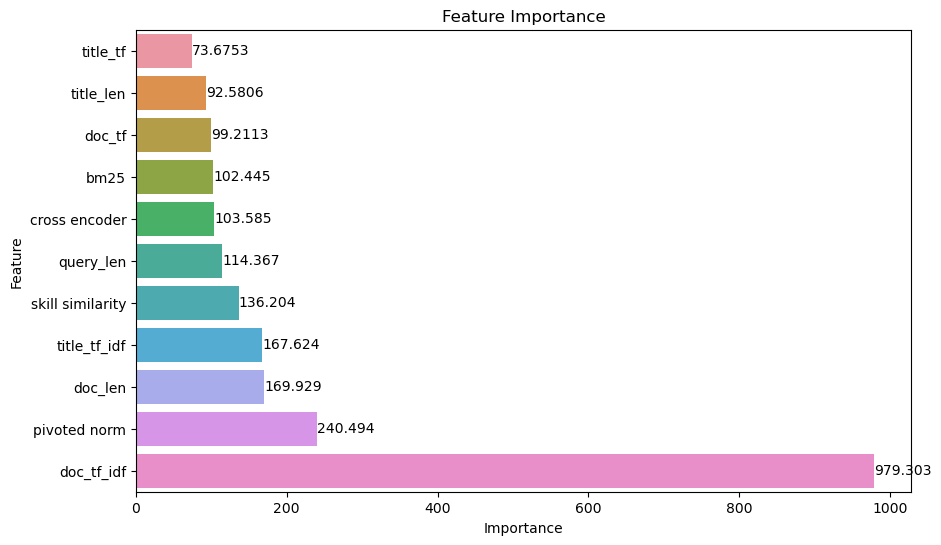

In [37]:
print('plot feature importance...')
feature_names = [
        'doc_len', 'title_len', 'query_len',
        'doc_tf', 'doc_tf_idf', 'title_tf', 'title_tf_idf',
        'bm25', 'pivoted norm', #'pagerank', 'HITS hub', 'HITS auth',
        'cross encoder',
        'skill similarity',
        #'title_myscore', 'doc_myscore', 'total_cat'
]
num_binary = len(feature_names)
num_cat = len(l2r_vr.model.ranker.feature_name_) - len(feature_names)
for i in range(num_cat):
    feature_names.append(f'cat{i}')
print("- number of used features", len(l2r_vr.model.ranker.feature_name_))
print(feature_names)
importance = l2r_vr.model.ranker.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
})
df_binary = importance_df.iloc[num_binary:]
df = importance_df.iloc[:num_binary]
df = df.sort_values(by=['importance'])

# Plot feature importance
print('plot feature importance...')
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x='importance', y='feature')
ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.savefig(FIG_PATH + 'feature_importance_vr.png')

print('binary features importance...')
df_binary = importance_df.iloc[num_binary:]
df_binary = df_binary.sort_values(by=['importance'], ascending=False)
print(df_binary.head(5))

## L2R with Document Augmentation Ranking

In [12]:
print("creating vector ranker...")
embeddings_aug = np.load(aug_embeddings_filename).astype(np.float32)

model_name = 'sentence-transformers/msmarco-MiniLM-L12-cos-v5'
ranker = VectorRanker(model_name, embeddings_aug, docids)

print("creating l2r ranker...")
l2r_vr_aug = L2RRanker(main_index, title_index, preprocessor,
                    stopwords, ranker, fe)

creating vector ranker...
creating l2r ranker...


In [13]:
print('training...')
l2r_vr_aug.train(training_filename, resume_data_filename, "l2r_vr_aug_train_data")

training...
load training data from path...
training...
[LightGBM] [Info] Total Bins 2811
[LightGBM] [Info] Number of data points in the train set: 73083, number of used features: 56


#### Scoring

In [14]:
scores['l2r_vr_aug'] = run_relevance_tests(resume_data_filename, testing_filename, l2r_vr_aug)
scores['l2r_vr_aug']

100%|██████████| 248/248 [1:46:09<00:00, 25.68s/it]


{'map': 0.021778513824884792,
 'ndcg': 0.047447290261550285,
 'map_list': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.034722222222222224,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.11666666666666665,
  0.01,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.19,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.45809523809523806,
  0.0,
  0.10333333333333335,
  0.05,
  0.01,
  0.03333333333333333,
  0.0,
  0.0,
  0.09583333333333333,
  0.0,
  0.0,
  0.31111111111111106,
  0.0,
  0.0,
  0.0,
  0.23603174603174604,
  0.03333333333333333,
  0.016666666666666666,
  0.0,
  0.025,
  0.0,
  0.03333333333333333,
  0.13333333333333333,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.01,
  0.0,
  0.0,
  0.03333333333333333,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.045,
  0.0,
  0.03333333333333333,
  0.0,
  0.0,
  0.0,
  0.25,
  0.016666666666666666,
  0.0,
  0.0,
  0.075,
  0.08333333333333333,
  0.0869047619047619,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.1,
  0.0,
  0.0,
  0.

In [15]:
save_score(scores, SCORE_PATH)

plot feature importance...
- number of used features 66
['doc_len', 'title_len', 'query_len', 'doc_tf', 'doc_tf_idf', 'title_tf', 'title_tf_idf', 'bm25', 'pivoted norm', 'cross encoder', 'skill similarity', 'cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54']
plot feature importance...
binary features importance...
   feature  importance
62   cat51  264.690920
50   cat39  228.431480
55   cat44  100.231319
30   cat19   25.307230
28   cat17   16.394110


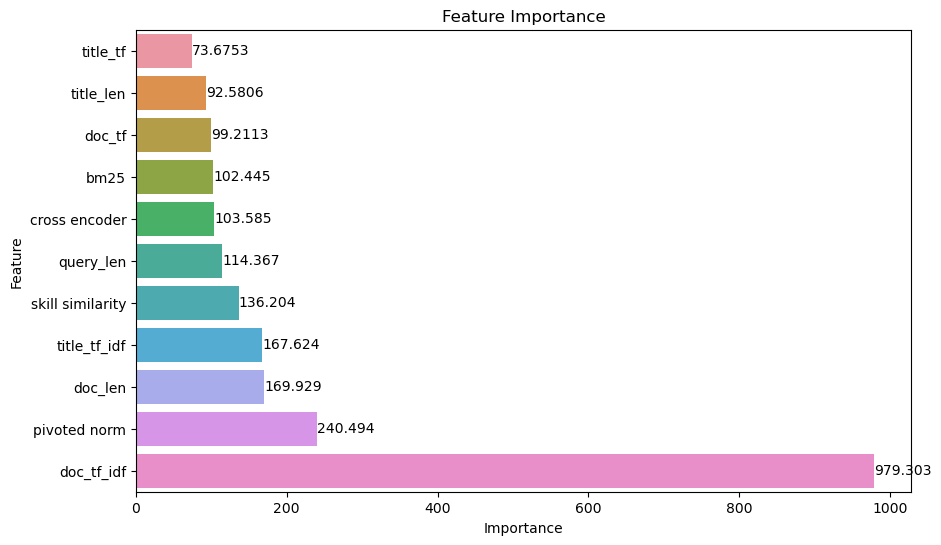

In [16]:
print('plot feature importance...')
feature_names = [
        'doc_len', 'title_len', 'query_len',
        'doc_tf', 'doc_tf_idf', 'title_tf', 'title_tf_idf',
        'bm25', 'pivoted norm', #'pagerank', 'HITS hub', 'HITS auth',
        'cross encoder',
        'skill similarity',
        #'title_myscore', 'doc_myscore', 'total_cat'
]
num_binary = len(feature_names)
num_cat = len(l2r_vr_aug.model.ranker.feature_name_) - len(feature_names)
for i in range(num_cat):
    feature_names.append(f'cat{i}')
print("- number of used features", len(l2r_vr_aug.model.ranker.feature_name_))
print(feature_names)
importance = l2r_vr_aug.model.ranker.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
})
df_binary = importance_df.iloc[num_binary:]
df = importance_df.iloc[:num_binary]
df = df.sort_values(by=['importance'])

# Plot feature importance
print('plot feature importance...')
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x='importance', y='feature')
ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.savefig(FIG_PATH + 'feature_importance_vr_aug.png')

print('binary features importance...')
df_binary = importance_df.iloc[num_binary:]
df_binary = df_binary.sort_values(by=['importance'], ascending=False)
print(df_binary.head(5))

## L2R with Document Augmentation and Company Rating Re-Ranking

In [17]:
print('creating company ratings dict')
company_ratings = {}
company_reviews = pd.read_csv(COMPANY_RATINGS_PATH, sep=';')
for idx, row in company_reviews.iterrows():
    if pd.isna(row['name']) or pd.isna(row['rating']):
        continue
    name = row['name'].lower()
    name = ''.join(char for char in name if char.isalnum())
    rating = round(float(row['rating']) / 5, 2)
    company_ratings[name] = rating

docid_to_company_rating = {}
with jsonlines.open(dataset_file_path) as f:
    for doc in tqdm(f):
        if pd.isna(doc['company_name']):
            continue
        name = doc['company_name'].lower()
        name = ''.join(char for char in name if char.isalnum())
        if name in company_ratings:
            docid_to_company_rating[doc['job_id']] = company_ratings[name]

creating company ratings dict


123842it [00:02, 45727.02it/s]


In [18]:
print("creating l2r ranker...")
l2r_cr = L2RRanker(main_index, title_index, preprocessor,
                    stopwords, ranker, fe, docid_to_company_rating)

creating l2r ranker...


In [19]:
print('training...')
l2r_cr.train(training_filename, resume_data_filename, "l2r_vr_aug_train_data")

training...
load training data from path...
training...
[LightGBM] [Info] Total Bins 2811
[LightGBM] [Info] Number of data points in the train set: 73083, number of used features: 56


#### Scoring

In [20]:
scores['l2r_cr'] = run_relevance_tests(resume_data_filename, testing_filename, l2r_cr)
scores['l2r_cr']

100%|██████████| 248/248 [1:45:37<00:00, 25.56s/it]


{'map': 0.02153801843317972,
 'ndcg': 0.0472226103425195,
 'map_list': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.034722222222222224,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.11666666666666665,
  0.01,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.19,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.45809523809523806,
  0.0,
  0.10333333333333335,
  0.05,
  0.01,
  0.03333333333333333,
  0.0,
  0.0,
  0.09583333333333333,
  0.0,
  0.0,
  0.31111111111111106,
  0.0,
  0.0,
  0.0,
  0.18047619047619048,
  0.025,
  0.016666666666666666,
  0.0,
  0.025,
  0.0,
  0.03333333333333333,
  0.13333333333333333,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.01111111111111111,
  0.0,
  0.0,
  0.03333333333333333,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.045,
  0.0,
  0.03333333333333333,
  0.0,
  0.0,
  0.0,
  0.25,
  0.016666666666666666,
  0.0,
  0.0,
  0.07166666666666666,
  0.08333333333333333,
  0.0869047619047619,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.1,
  0.0,

In [23]:
save_score(scores, SCORE_PATH)

## Plot

In [24]:
scores = load_score(SCORE_PATH)

In [25]:
queries = list(pd.read_csv(testing_filename)['resume_id'].value_counts().index)

number of queries 248


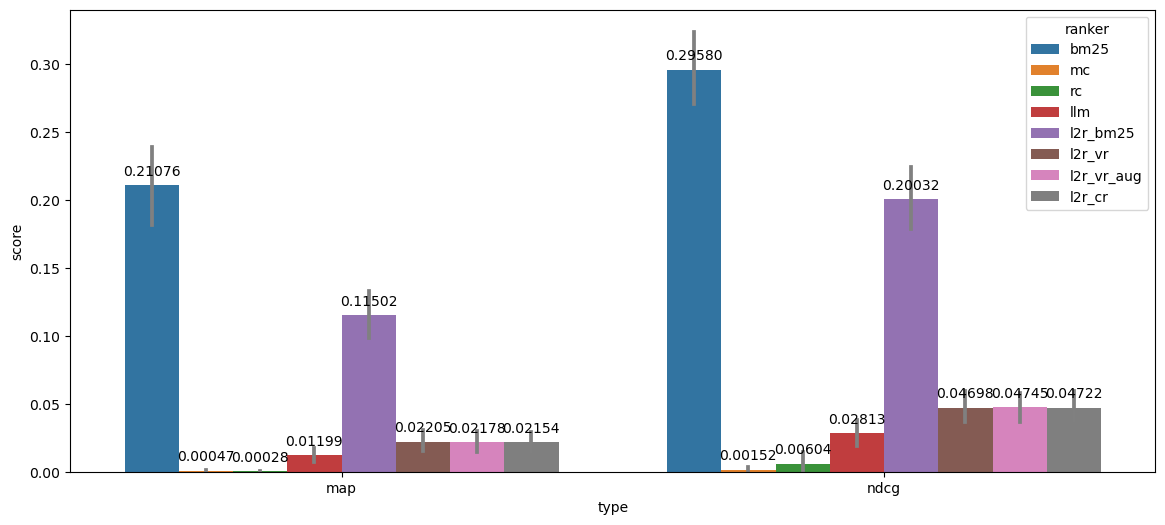

In [44]:
df = []
print("number of queries", len(queries))
for i in range(len(queries)):
    for ranker in scores.keys():
        df.append({'ranker': ranker, 'type': 'map', 'score': scores[ranker]['map_list'][i]})
        df.append({'ranker': ranker, 'type': 'ndcg', 'score': scores[ranker]['ndcg_list'][i]})
df = pd.DataFrame(df)

plt.figure(figsize=(14, 6))
ax = sns.barplot(x='type', y='score', hue='ranker', data=df, errcolor='grey')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.5f}', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
plt.savefig(FIG_PATH + 'ranker_scores.png')

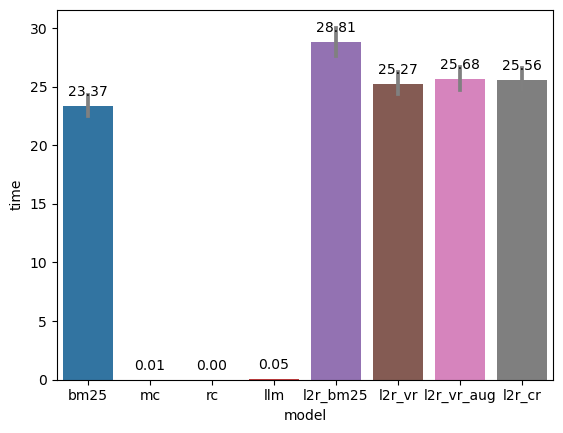

In [37]:
df = []
for i in range(len(queries)):
    for ranker in scores.keys():
        df.append({'model': ranker, 'time': scores[ranker]['time'][i]})
    
df = pd.DataFrame(df)
ax = sns.barplot(x='model', y='time', data=df, errcolor="grey")
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
plt.savefig(FIG_PATH + 'ranking_time.png')

# Fairness Analysis

In [38]:
MODEL = 'l2r_cr'
testing_resume_data = list(set(pd.read_csv(testing_filename)['resume_id'].tolist()))
resume_data = pd.read_csv(resume_data_filename)
cat = []
for resume_id in testing_resume_data:
    cat.append(resume_data[resume_data['ID'] == resume_id]["Category"].item())
df = pd.DataFrame({ "resume_id": testing_resume_data, "map": scores[MODEL]['map_list'], "ndcg": scores[MODEL]['ndcg_list'], "category": cat })
df.head(5)

,resume_id,map,ndcg,category
0,51432451,0.0,0.000000,CONSULTANT
1,25926667,0.0,0.000000,ARTS
2,28186635,0.0,0.000000,AVIATION
3,49285644,0.0,0.000000,TEACHER
4,39608848,0.0,0.016393,ARTS


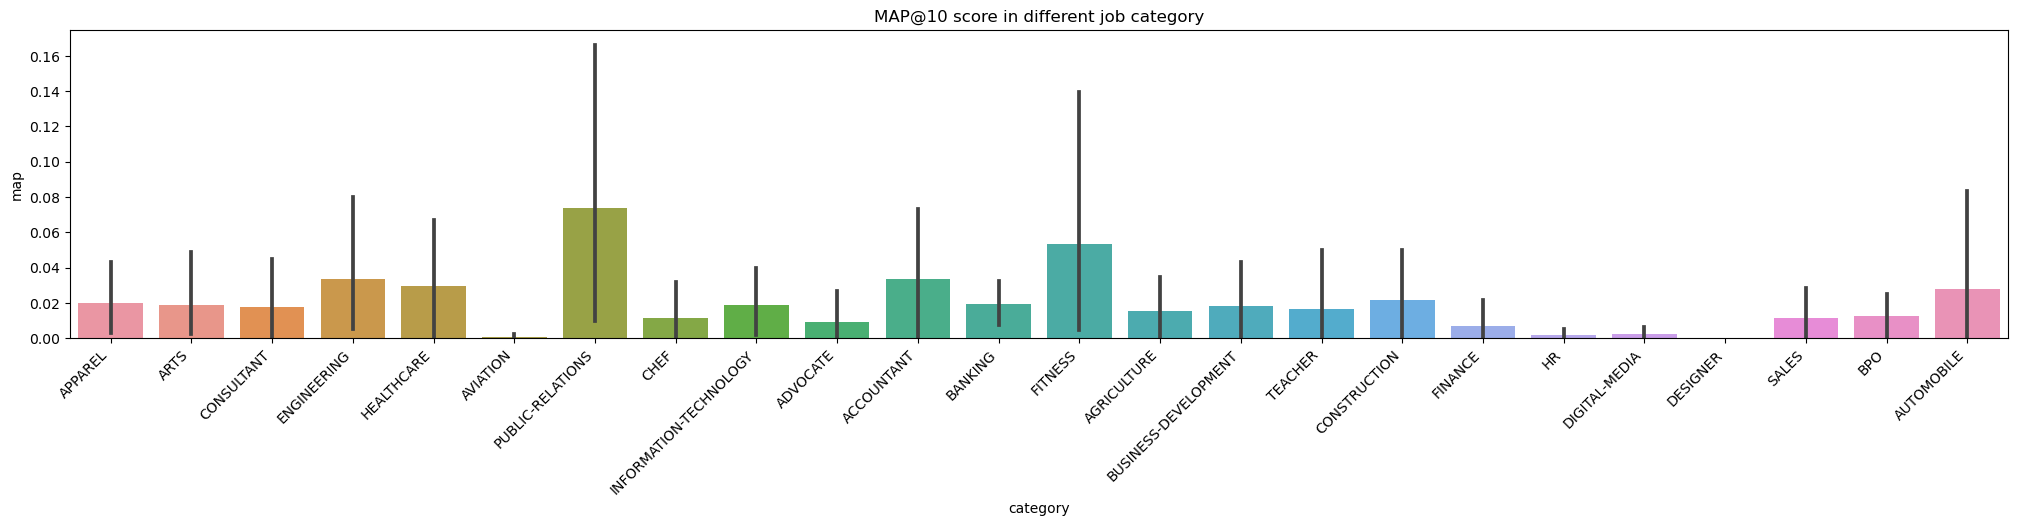

In [39]:
plt.figure(figsize=(25, 4))
label_order = df['category'].value_counts().index.tolist()
sns.barplot(
    data=df,
    x='category', y='map',
    order=label_order
)
plt.title(f"MAP@10 score in different job category")
plt.xticks(rotation=45, ha="right")
# # plt.tight_layout()
plt.savefig(FIG_PATH + f"fairness_in_MAP.png")  # Save each plot as PDF
plt.show()

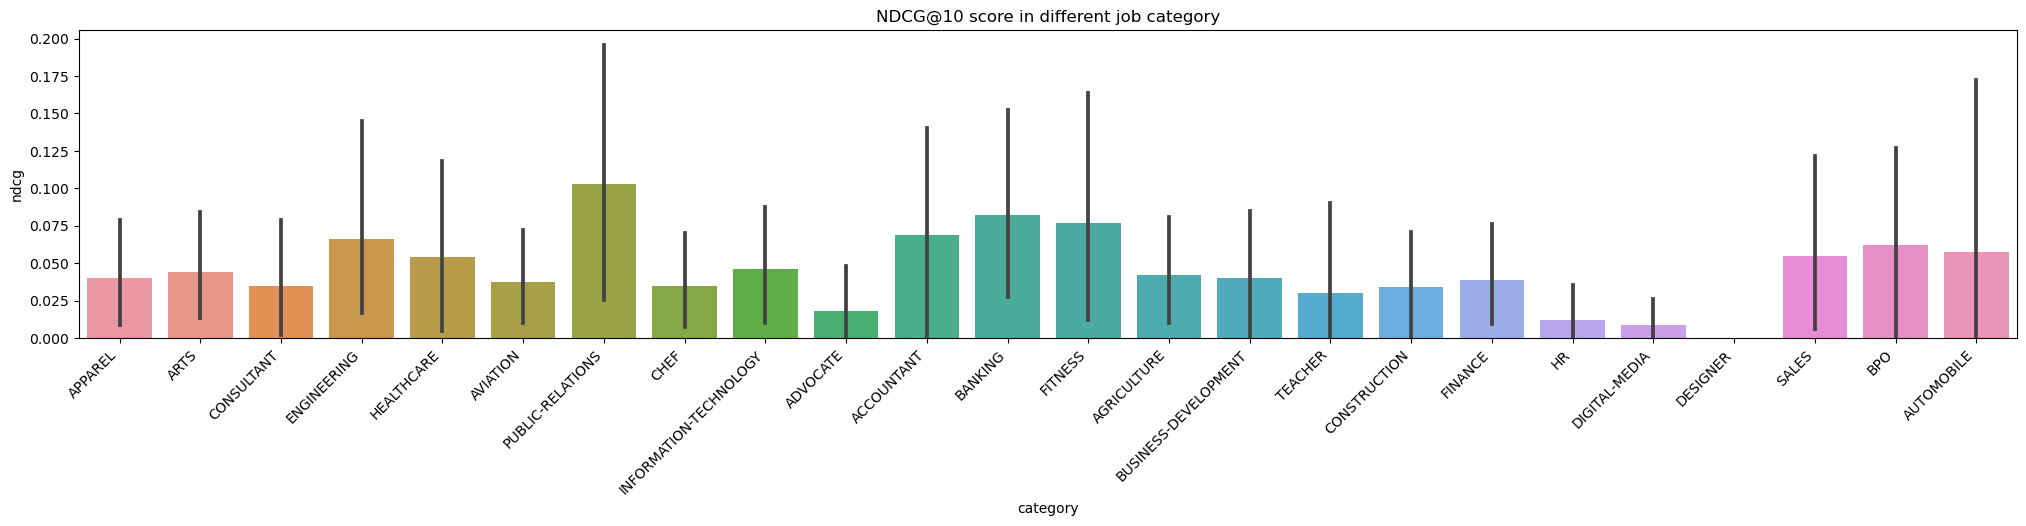

In [40]:
plt.figure(figsize=(25, 4))
label_order = df['category'].value_counts().index.tolist()
sns.barplot(
    data=df,
    x='category', y='ndcg',
    order=label_order
)
plt.title(f"NDCG@10 score in different job category")
plt.xticks(rotation=45, ha="right")
# # plt.tight_layout()
plt.savefig(FIG_PATH + f"fairness_in_NDCG.png")  # Save each plot as PDF
plt.show()